# Model Training (Keras)

## Configuration

In [1]:
# The parameter file is where the hyperparameters are set

from parameters import *

## Library

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LeakyReLU
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import numpy as np
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.models import load_model

# Disable some console warnings
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-11-21 21:41:04.203139: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 21:41:04.203222: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 21:41:04.203263: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 21:41:04.208118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
seed = 0

# Input seed value. if this value is the same, the random number generator will generate the same set of random values every time
np.random.seed(seed)

# Set the seed value for reproducibility in tensorflow
tf.random.set_seed(seed)

## Check GPU

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15808219167710147447
xla_global_id: -1
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7445569377933388680
physical_device_desc: "device: XLA_CPU device"
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8502378496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4996616027427115247
physical_device_desc: "device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:00:10.0, compute capability: 8.0"
xla_global_id: 416903419
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7108101518454173127
physical_device_desc: "device: XLA_GPU device"
xla_global_id: -1
]


2024-11-21 21:41:12.569174: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x565315121470 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-11-21 21:41:12.569241: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-11-21 21:41:12.569397: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-11-21 21:41:12.708682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-21 21:41:12.741992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least o

## Dataset

### Load

In [5]:
if DATA_AUGMENTATION:
    X_train_val = np.load('{}/npy/x_train_val_augmented.npy'.format(DATA_DIR), allow_pickle=True)
    X_test = np.load('{}/npy/x_test_augmented.npy'.format(DATA_DIR), allow_pickle=True)

    if 'One Hot' in ENCODING_TYPE:
        y_train_val = np.load('{}/npy/y_train_val_augmented_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_test = np.load('{}/npy/y_test_augmented_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
    elif 'Linear' in ENCODING_TYPE:
        y_train_val = np.load('{}/npy/y_train_val_augmented_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_test = np.load('{}/npy/y_test_augmented_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
    elif 'Try Both' in ENCODING_TYPE:
        y_train_val_one_hot_encoding = np.load('{}/npy/y_train_val_augmented_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_test_one_hot_encoding = np.load('{}/npy/y_test_augmented_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_train_val_linear_encoding = np.load('{}/npy/y_train_val_augmented_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_test_linear_encoding = np.load('{}/npy/y_test_augmented_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
            
else:
    X_train_val = np.load('{}/npy/x_train_val.npy'.format(DATA_DIR), allow_pickle=True)
    X_test = np.load('{}/npy/x_test.npy'.format(DATA_DIR), allow_pickle=True)
    
    if 'One Hot' in ENCODING_TYPE:
        y_train_val = np.load('{}/npy/y_train_val_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_test = np.load('{}/npy/y_test_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
    elif 'Linear' in ENCODING_TYPE:
        y_train_val = np.load('{}/npy/y_train_val_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_test = np.load('{}/npy/y_test_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
    elif 'Try Both' in ENCODING_TYPE:
        y_train_val_one_hot_encoding = np.load('{}/npy/y_train_val_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_test_one_hot_encoding = np.load('{}/npy/y_test_one_hot_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_train_val_linear_encoding = np.load('{}/npy/y_train_val_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)
        y_test_linear_encoding = np.load('{}/npy/y_test_linear_encoding.npy'.format(DATA_DIR), allow_pickle=True)

### Visualize

In [6]:
if 'Try Both' not in ENCODING_TYPE:
    print('X_train_val.shape: ', X_train_val.shape)
    print('y_train_val.shape: ', y_train_val.shape)
    print('y_train_val[0]: ', y_train_val[0])
else:
    print('X_train_val.shape: ', X_train_val.shape)
    print('y_train_val_one_hot_encoding.shape: ', y_train_val_one_hot_encoding.shape)
    print('y_train_val_one_hot_encoding[0]: ', y_train_val_one_hot_encoding[0])
    print('y_train_val_linear_encoding.shape: ', y_train_val_linear_encoding.shape)
    print('y_train_val_linear_encoding[0]: ', y_train_val_linear_encoding[0])

X_train_val.shape:  (972, 2)
y_train_val_one_hot_encoding.shape:  (972, 45)
y_train_val_one_hot_encoding[0]:  [0.00000000e+00 0.00000000e+00 4.03940887e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.14285714e-01 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 3.26585020e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.30013001e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.00025001e-05 0.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
y_train_val_linear_encoding.shape:  (972, 43)
y_train_val_linear_encoding[0]:  [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 4.03940887e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

In [7]:
display(X_train_val) #can check this in previous script as well after loading to make sure it matches

array([[0.06143168, 0.1222459 ],
       [0.04092692, 0.07230281],
       [0.51113395, 0.00118874],
       ...,
       [0.05754841, 0.25609945],
       [0.57781303, 0.0013409 ],
       [0.06168676, 0.26742149]])

In [8]:
#number of values in the training set and test set, these are probably pulling from the data files individual points
total = len(X_train_val) + len(X_test)
print('---------------------------------------')  
print('Train-and-validation set shape x: {}, {:.2f}%'.format(len(X_train_val), (len(X_train_val)*100.)/total))
print('Test set shape x:                 {}, {:.2f}%'.format(len(X_test), (len(X_test)*100.)/total))
print('---------------------------------------')

if 'Try Both' not in ENCODING_TYPE:
    total = len(y_train_val) + len(y_test)
    print('---------------------------------------')  
    print('Train-and-validation set shape y: {}, {:.2f}%'.format(len(y_train_val), (len(y_train_val)*100.)/total))
    print('Test set shape y:                 {}, {:.2f}%'.format(len(y_test), (len(y_test)*100.)/total))
    print('---------------------------------------')
else:
    total = len(y_train_val_one_hot_encoding) + len(y_test_one_hot_encoding)
    print('---------------------------------------')
    print('Train-and-validation one-hot encoding set shape: {}, {:.2f}%'.format(len(y_train_val_one_hot_encoding), (len(y_train_val_one_hot_encoding)*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(len(y_test_one_hot_encoding), (len(y_test_one_hot_encoding)*100.)/total))
    print('---------------------------------------')
    
    total = len(y_train_val_linear_encoding) + len(y_test_linear_encoding)
    print('---------------------------------------')
    print('Train-and-validation linear encoding set shape: {}, {:.2f}%'.format(len(y_train_val_linear_encoding), (len(y_train_val_linear_encoding)*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(len(y_test_linear_encoding), (len(y_test_linear_encoding)*100.)/total))
    print('---------------------------------------')

---------------------------------------
Train-and-validation set shape x: 972, 79.93%
Test set shape x:                 244, 20.07%
---------------------------------------
---------------------------------------
Train-and-validation one-hot encoding set shape: 972, 79.93%
Test set shape:                 244, 20.07%
---------------------------------------
---------------------------------------
Train-and-validation linear encoding set shape: 972, 79.93%
Test set shape:                 244, 20.07%
---------------------------------------


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

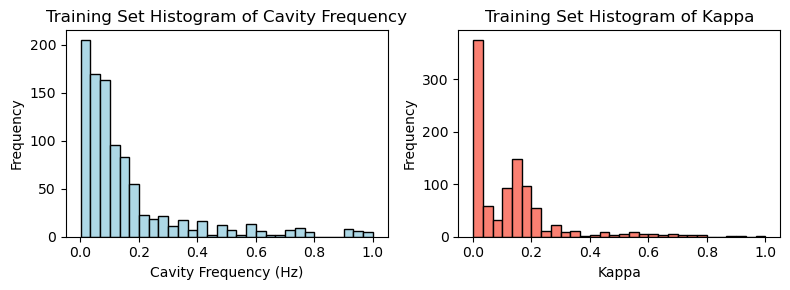

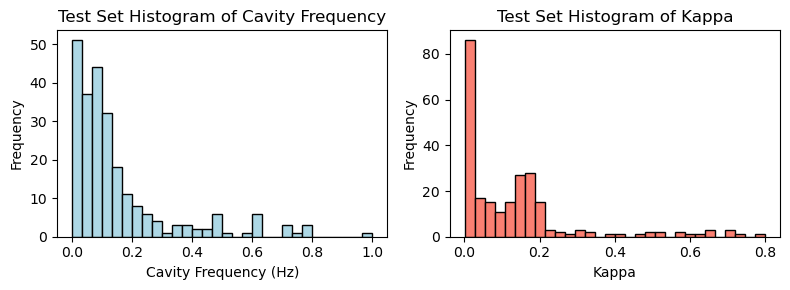

In [10]:
#--------------------Training Set---------------------
plt.figure(figsize=(8, 3))

# Histogram for Cavity Frequency
plt.subplot(1, 2, 1)
plt.hist([i[0] for i in X_train_val], bins=30, color='lightblue', edgecolor='black')
plt.title('Training Set Histogram of Cavity Frequency')
plt.xlabel('Cavity Frequency (Hz)')
plt.ylabel('Frequency')

# Histogram for Kappa
plt.subplot(1, 2, 2)
plt.hist([i[1] for i in X_train_val], bins=30, color='salmon', edgecolor='black')
plt.title('Training Set Histogram of Kappa')
plt.xlabel('Kappa')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#--------------------Test Set---------------------
plt.figure(figsize=(8, 3))

# Histogram for Cavity Frequency
plt.subplot(1, 2, 1)
plt.hist([i[0] for i in X_test], bins=30, color='lightblue', edgecolor='black')
plt.title('Test Set Histogram of Cavity Frequency')
plt.xlabel('Cavity Frequency (Hz)')
plt.ylabel('Frequency')

# Histogram for Kappa
plt.subplot(1, 2, 2)
plt.hist([i[1] for i in X_test], bins=30, color='salmon', edgecolor='black')
plt.title('Test Set Histogram of Kappa')
plt.xlabel('Kappa')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## MLP

### Create model

Create a classical multi-layer perceptron for regression: 602 input features, 10 targets, and a certain number of hidden layers and neurons. Taking some inspiration from [Deep learning-based I-V Global Parameter Extraction for BSIM-CMG](https://www.sciencedirect.com/science/article/pii/S003811012300179X), Solid-State Electronics, Vol. 209, November 2023.

Reccomended to download a third party app like "Sleep control Center" or "Amphetamine" to prevent computer from sleeping during the many hour/day long training process

### Create Model by Hand

In [11]:
# n output neurons for n parameters
if 'Try Both' not in ENCODING_TYPE:
    # Multilayer perceptron (MLP) with 2 input features. MLP is having neurons that adjust rules based on how accurate they can guess things
    model_shape = f'mlp_{len(X_test[0])}_'
    
    # Define the number on neurons in the inner layer (in parameter file)
    model_shape += '_'.join(str(l) for l in NEURONS_PER_LAYER)

    print(len(y_train_val[0]))
    model_shape += f'_{len(y_train_val[0])}'
else:
    # Multilayer perceptron (MLP) with 2 input features. MLP is having neurons that adjust rules based on how accurate they can guess things
    model_shape_one_hot_encoding = f'mlp_{len(X_test[0])}_'
    model_shape_linear_encoding = f'mlp_{len(X_test[0])}_'
    
    # Define the number on neurons in the inner layer (in parameter file)
    model_shape_one_hot_encoding += '_'.join(str(l) for l in NEURONS_PER_LAYER)
    model_shape_linear_encoding += '_'.join(str(l) for l in NEURONS_PER_LAYER)

    print('one hot: ',len(y_train_val_one_hot_encoding[0]))
    model_shape_one_hot_encoding += f'_{len(y_train_val_one_hot_encoding[0])}'
    print('linear: ',len(y_train_val_linear_encoding[0]))
    model_shape_linear_encoding += f'_{len(y_train_val_linear_encoding[0])}'


one hot:  45
linear:  43


In [13]:
if 'Try Both' not in ENCODING_TYPE:
    # Initialize a sequential model, which lets us build a linear stack of layers
    model = Sequential()
    
    # Add an input layer to the model. This layer defines the shape of the input data (2 features per sample), sets dimensions of following layers
    model.add(Input(shape=(len(X_test[0])), name='input1'))
    
    # Iterate over the configuration of neurons for each hidden layer specified in NEURONS_PER_LAYER
    for i, n in enumerate(NEURONS_PER_LAYER):
        # Add a fully connected (dense) hidden layer with spec ified number of neurons
        # The LeCun uniform initializer is used when initializing weights, this makes the model more stable
        # L2 regularization is used in each layer to penalizing large weights, which prevents overfitting
        model.add(Dense(n, name='fc{}'.format(i), kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    
        # Apply a Leaky ReLU activation function to the outputs of the dense layer
        # This introduces non-linearities, allowing the network to learn complex functions
        # Leaky ReLU is chosen over standard ReLU to help mitigate the "dying ReLU" problem:
        #     - This problem is when neurons using the ReLU activation function output zero for all inputs and stop learning
        #     - Can be mitigated by using variations like Leaky ReLU or proper initialization
        model.add(LeakyReLU(alpha=0.01, name='leaky_relu{}'.format(i)))
        
        # Add a dropout layer to reduce overfitting -- randomly drops a set fraction (like 30%) of outputs from the layer
        model.add(Dropout(rate=TRAIN_DROPOUT_RATE, name='dropout{}'.format(i)))
    
    # Add the output layer consisting of # neurons, corresponding to the # target variables we aim to predict.
    # The same LeCun uniform initializer is used to ensure consistency and stability at the output layer as well.
    model.add(Dense(len(y_train_val[0]), activation='linear', name='fc_output', kernel_initializer='lecun_uniform'))

else:
    model_one_hot_encoding = Sequential()
    model_one_hot_encoding.add(Input(shape=(len(X_test[0])), name='input1'))
    for i, n in enumerate(NEURONS_PER_LAYER):
        model_one_hot_encoding.add(Dense(n, name='fc{}'.format(i), kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model_one_hot_encoding.add(LeakyReLU(alpha=0.01, name='leaky_relu{}'.format(i)))
        model_one_hot_encoding.add(Dropout(rate=TRAIN_DROPOUT_RATE, name='dropout{}'.format(i)))
    model_one_hot_encoding.add(Dense(len(y_train_val_one_hot_encoding[0]), activation='linear', name='fc_output', kernel_initializer='lecun_uniform'))

    model_linear_encoding = Sequential()
    model_linear_encoding.add(Input(shape=(len(X_test[0])), name='input1'))
    for i, n in enumerate(NEURONS_PER_LAYER):
        model_linear_encoding.add(Dense(n, name='fc{}'.format(i), kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model_linear_encoding.add(LeakyReLU(alpha=0.01, name='leaky_relu{}'.format(i)))
        model_linear_encoding.add(Dropout(rate=TRAIN_DROPOUT_RATE, name='dropout{}'.format(i)))
    model_linear_encoding.add(Dense(len(y_train_val_linear_encoding[0]), activation='linear', name='fc_output', kernel_initializer='lecun_uniform'))

In [14]:
# The exponential decay learning rate schedule gradually reduces the learning rate, fine-tuning the learning process for better convergence
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LR_INITIAL,  
    decay_steps=LR_DECAY_STEPS,        
    decay_rate=LR_DECAY_RATE,          
    staircase=LR_STAIRCASE             
)

if 'Try Both' not in ENCODING_TYPE:
    # Set model to minimize loss specified by TRAIN_LOSS, and also to report the loss during training
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),  
        loss=TRAIN_LOSS,                                         
        metrics=[TRAIN_LOSS]                                     
    )
else:
    # Set model to minimize loss specified by TRAIN_LOSS, and also to report the loss during training
    model_linear_encoding.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),  
        loss=TRAIN_LOSS,                                         
        metrics=[TRAIN_LOSS]                                     
    )
    model_one_hot_encoding.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr_schedule),  
        loss=TRAIN_LOSS,                                         
        metrics=[TRAIN_LOSS]                                     
    )

2024-11-21 21:42:09.374686: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [21]:
!mkdir -p model
if 'Try Both' not in ENCODING_TYPE:
    best_model_file = 'model/{}_best_model.h5'.format(model_shape)
    last_model_file = 'model/{}_last_model.h5'.format(model_shape)
else:
    best_model_file_one_hot_encoding = 'model/{}_best_model_one_hot_encoding.h5'.format(model_shape_one_hot_encoding)
    last_model_file_one_hot_encoding = 'model/{}_last_model_one_hot_encoding.h5'.format(model_shape_one_hot_encoding)

    best_model_file_linear_encoding = 'model/{}_best_model_linear_encoding.h5'.format(model_shape_linear_encoding)
    last_model_file_linear_encoding = 'model/{}_last_model_linear_encoding.h5'.format(model_shape_linear_encoding)

Enable training (`train_and_save`) to overwrite the model file.

In [22]:
train_and_save = True

We use Adam optimizer, minimize the Mean Squared Logarithmic Error, and early stop.

#### Training

In [23]:
from IPython.display import clear_output

class TrainingPlot(tf.keras.callbacks.Callback):
     
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses 
        self.losses = []
        self.val_losses = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses  to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.title("Training Loss [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()
       
class LearningRateMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super(LearningRateMonitor, self).__init__()
        self.learning_rates = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer._current_learning_rate.read_value()
        self.learning_rates.append(lr)
        print(f"Epoch: {epoch + 1}, Learning Rate: {lr:.10f}")

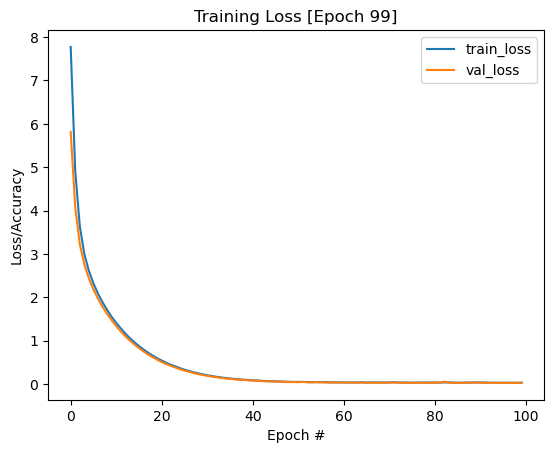

Epoch: 100, Learning Rate: 0.0011324665
25/25 [==============================] - 0s 15ms/step - loss: 0.0281 - mean_squared_error: 0.0150 - val_loss: 0.0292 - val_mean_squared_error: 0.0160
CPU times: user 1min 36s, sys: 40 s, total: 2min 16s
Wall time: 2min 1s


In [25]:
%%time
history = None  

if train_and_save: 
    # Set up early stopping to prevent overfitting by halting training when validation loss stops improving
    early_stopping = EarlyStopping(
        monitor='val_loss',                      # Monitor validation loss for stopping criteria 
        mode='min',                              # Stop when the monitored quantity has stopped decreasing
        patience=TRAIN_EARLY_STOPPING_PATIENCE,  # Number of epochs to wait after last improvement
        verbose=1                                # Enable logging when early stopping happens
    )

    # Train the model on the training data and validate on a portion of it
    if 'Try Both' not in ENCODING_TYPE:
        plot_callback = TrainingPlot()      # Plot training progress
        lr_monitor = LearningRateMonitor()  # Watch learning rate changes
        
        # Set up model checkpointing to save the model at its best validation loss:
        model_checkpoint = ModelCheckpoint(
            filepath=best_model_file,          
            monitor='val_loss',            # Save the model based on validation loss improvement
            mode='min',                    # Favor lower validation loss values for saving (minimize)
            save_best_only=True,           # Save only when validation loss improves
            verbose=0                      # No logging for model saving
        )
        history = model.fit(
            np.asarray(X_train_val),  
            np.asarray(y_train_val),      
            epochs=100,                   
            batch_size=TRAIN_BATCH_SIZE,  
            validation_split=TRAIN_VALIDATION_SPLIT,  
            callbacks=[early_stopping, model_checkpoint, plot_callback, lr_monitor],  
            verbose=1  # Enable logging of the training process.
        )
        
        model.save(last_model_file)  # Save the final model when done training!
    
    else:
        #-----------------------------------------linear--------------------------------------------
        plot_callback_linear_encoding = TrainingPlot()      # Plot training progress
        lr_monitor_linear_encoding = LearningRateMonitor()  # Watch learning rate changes
        
        # Set up model checkpointing to save the model at its best validation loss:
        model_checkpoint_linear_encoding = ModelCheckpoint(
            filepath=best_model_file_linear_encoding,          
            monitor='val_loss',            # Save the model based on validation loss improvement
            mode='min',                    # Favor lower validation loss values for saving (minimize)
            save_best_only=True,           # Save only when validation loss improves
            verbose=0                      # No logging for model saving
        )
        
        history_linear_encoding = model_linear_encoding.fit(
            np.asarray(X_train_val),  
            np.asarray(y_train_val_linear_encoding),      
            epochs=100,                   
            batch_size=TRAIN_BATCH_SIZE,  
            validation_split=TRAIN_VALIDATION_SPLIT,  
            callbacks=[early_stopping, model_checkpoint_linear_encoding, plot_callback_linear_encoding, lr_monitor_linear_encoding],  
            verbose=1  # Enable logging of the training process.
        )
        
        model_linear_encoding.save(last_model_file_linear_encoding)  # Save the final model when done training!
        
        #-----------------------------------------one hot--------------------------------------------
        plot_callback_one_hot_encoding = TrainingPlot()      # Plot training progress
        lr_monitor_one_hot_encoding = LearningRateMonitor()  # Watch learning rate changes
        
        # Set up model checkpointing to save the model at its best validation loss:
        model_checkpoint_one_hot_encoding = ModelCheckpoint(
            filepath=best_model_file_one_hot_encoding,          
            monitor='val_loss',            # Save the model based on validation loss improvement
            mode='min',                    # Favor lower validation loss values for saving (minimize)
            save_best_only=True,           # Save only when validation loss improves
            verbose=0                      # No logging for model saving
        )
        
        history_one_hot_encoding = model_one_hot_encoding.fit(
            np.asarray(X_train_val),  
            np.asarray(y_train_val_one_hot_encoding),      
            epochs=100,                   
            batch_size=TRAIN_BATCH_SIZE,  
            validation_split=TRAIN_VALIDATION_SPLIT,  
            callbacks=[early_stopping, model_checkpoint_one_hot_encoding, plot_callback_one_hot_encoding, lr_monitor_one_hot_encoding],  
            verbose=1  # Enable logging of the training process.
        )
        
        model_one_hot_encoding.save(last_model_file_one_hot_encoding)  # Save the final model when done training!


Load the saved best model and use it from now on.

In [26]:
model_one_hot_encoding = load_model(best_model_file_one_hot_encoding, custom_objects={})
model_linear_encoding = load_model(best_model_file_linear_encoding, custom_objects={})

### Keras Tuner to Find Best Hyperparameters and Model

Run this if you want to use keras tuner to make the model rather than doing it by hand

In [27]:
if KERAS_TUNER:
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, Input, Dropout
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras_tuner import HyperModel, RandomSearch
    from tensorflow.keras.models import load_model

In [28]:
if KERAS_TUNER:
    def build_hypermodel(hp):
        # Hyperparameters to tune
        neurons_per_layer = [hp.Int(f'neurons_{i}', min_value=100, max_value=5000, step=100) for i in range(4)]
        dropout_rate = hp.Float('dropout_rate', TRAIN_DROPOUT_RATE, 0.5, step=0.1)
        
        # Create Model in the same way that we do by hand
        model = Sequential()
        model.add(Input(shape=(2,), name='input1'))
    
        for i, n in enumerate(neurons_per_layer):
            model.add(Dense(n, name=f'fc{i}', kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
            model.add(LeakyReLU(alpha=0.01, name=f'leaky_relu{i}'))
            model.add(Dropout(rate=dropout_rate, name=f'dropout{i}'))
    
        model.add(Dense(45, name='output', kernel_initializer='lecun_uniform'))
    
        # Learning rate configuration
        lr_initial = hp.Float('learning_rate', 1e-6, 5e-3, sampling='LOG', default=0.0001)
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr_initial,
            decay_steps=LR_DECAY_STEPS,
            decay_rate=LR_DECAY_RATE,
            staircase=LR_STAIRCASE
        )
    
        model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), 
                      loss='mean_squared_error',
                      metrics=['mean_squared_error'])
        return model

In [29]:
if KERAS_TUNER:
    # Start tuning
    tuner = RandomSearch(
        build_hypermodel,
        objective='val_loss',
        max_trials=31,
        executions_per_trial=1,
        directory='hyper_tuning',
        project_name='mlp_tuning'
    )

In [30]:
if KERAS_TUNER:
    # Setup Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=TRAIN_EARLY_STOPPING_PATIENCE,
        verbose=1
    )

In [31]:
if KERAS_TUNER:
    # Perform hyperparameter tuning
    tuner.search(np.asarray(X_train_val), 
                 np.asarray(y_train_val), 
                 epochs=50, 
                 batch_size=TRAIN_BATCH_SIZE, 
                 validation_split=TRAIN_VALIDATION_SPLIT, 
                 callbacks=[early_stopping], 
                 verbose=1)

In [32]:
if KERAS_TUNER:
    model = tuner.get_best_models(num_models=1)[0]
    print(model)

In [33]:
if KERAS_TUNER:
    best_model_file = 'model/best_keras_model.h5'
    model.save(best_model_file)
    
    model = load_model(best_model_file)

### View the model

In [34]:
if KERAS_TUNER:
    model.summary()

In [35]:
if KERAS_TUNER:
    tf.keras.utils.plot_model(model, to_file='{}_model.png'.format(model_shape), show_shapes=True, show_layer_names=True)

### Evaluation

Although we may plot and print many metrics, we focus only on **Mean Squared Error (MSE).**

Plot training history.

In [36]:
#%matplotlib ipympl
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

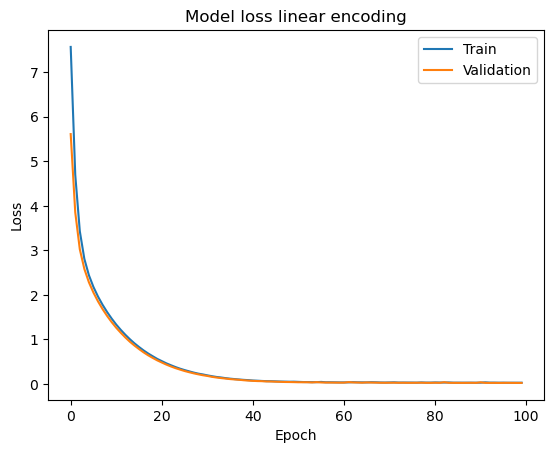

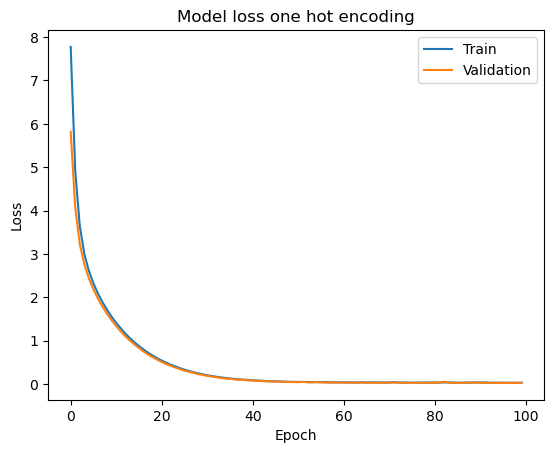

In [37]:
if 'Try Both' not in ENCODING_TYPE:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
else:
    plt.plot(history_linear_encoding.history['loss'])
    plt.plot(history_linear_encoding.history['val_loss'])
    plt.title('Model loss linear encoding')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

    plt.plot(history_one_hot_encoding.history['loss'])
    plt.plot(history_one_hot_encoding.history['val_loss'])
    plt.title('Model loss one hot encoding')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

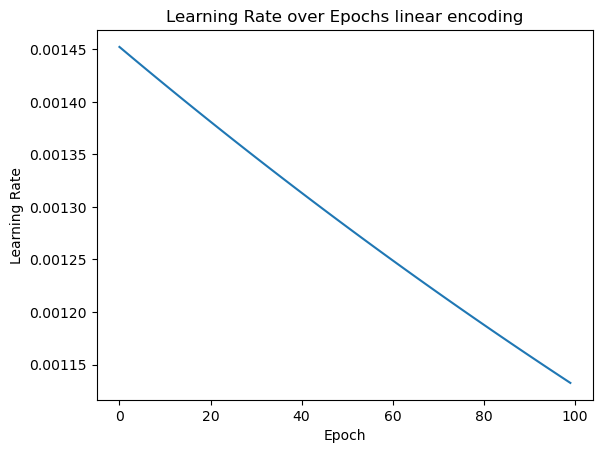

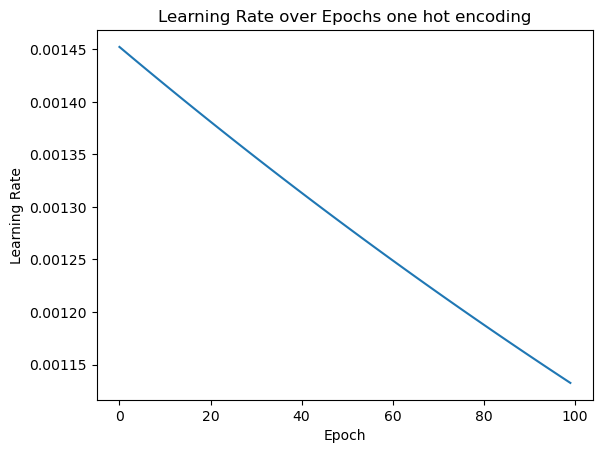

In [38]:
if 'Try Both' not in ENCODING_TYPE:
    plt.plot(lr_monitor.learning_rates)
    plt.title("Learning Rate over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.show()
else:
    plt.plot(lr_monitor_linear_encoding.learning_rates)
    plt.title("Learning Rate over Epochs linear encoding")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.show()

    plt.plot(lr_monitor_one_hot_encoding.learning_rates)
    plt.title("Learning Rate over Epochs one hot encoding")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.show()

Measure and print metrics.

In [44]:
if 'Try Both' not in ENCODING_TYPE:
    test_loss_result = model.evaluate(np.asarray(X_test), np.asarray(y_test))[0]
    print(y_test[0])
    print('test_loss_result: ', test_loss_result)
else:
    test_loss_result_linear_encoding = model_linear_encoding.evaluate(np.asarray(X_test), np.asarray(y_test_linear_encoding))[0]
    test_loss_result_one_hot_encoding = model_one_hot_encoding.evaluate(np.asarray(X_test), np.asarray(y_test_one_hot_encoding))[0]

    print(y_test_linear_encoding[0])
    print(y_test_linear_encoding[0])
    
    print('Current loss linear encoding {}: {}'.format(TRAIN_LOSS, test_loss_result_linear_encoding))
    print('Current loss one hot encoding {}: {}'.format(TRAIN_LOSS, test_loss_result_one_hot_encoding))

8/8 [==============================] - 0s 3ms/step - loss: 0.0236 - mean_squared_error: 0.0106
[1.         0.         0.         0.         0.03940887 0.
 0.         0.         0.         0.         0.         0.
 1.         1.         1.         0.         1.         0.
 0.         1.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.        ]
[1.         0.         0.         0.         0.03940887 0.
 0.         0.         0.         0.         0.         0.
 1.         1.         1.         0.         1.         0.
 0.         1.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         1.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.        ]
Current loss linear encoding mean_squared_error: 0.02

## Compare predictions vs. test set

In [53]:
import csv
if 'Try Both' not in ENCODING_TYPE:
    csv_data = [[
        DATA_AUGMENTATION,
        model_shape,
        ENCODING_TYPE,
        test_loss_result,
        TRAIN_LOSS,
        TRAIN_DROPOUT_RATE,
        TRAIN_EARLY_STOPPING_PATIENCE,
        TRAIN_BATCH_SIZE,
        TRAIN_VALIDATION_SPLIT,
        LR_INITIAL,
        LR_DECAY_STEPS,
        LR_DECAY_RATE,
        LR_STAIRCASE
        ]]
    
    csv_file = 'history_losses.csv'  #this doesnt reqrite this file so you need to delete this if you want something fresh
    
    if not os.path.exists(csv_file):
        with open(csv_file, 'w') as file:
            file.write('data_augmentation,model_shape,encoding_type,test_loss,train_loss,train_dropout_rate,train_early_stop_patience,'+
                        'train_batch_size,train_val_split,lr_initial,lr_decay_step,lr_decay_rate,lr_stair_case\n')
    
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)
    
    # Convert data to DataFrame for easier display
    df = pd.read_csv(csv_file)
    
    def color_red_column(s):
        return ['color: red' if v else '' for v in s]
    
    styled_df = df.style.apply(color_red_column, subset=['test_loss'])
    
    # Display the DataFrame as a table
    display(styled_df)
    #qgrid_widget = qgrid.show_grid(df, show_toolbar=True)

else:
    #---------------------------------------------------one hot---------------------------------------
    csv_data = [[
        DATA_AUGMENTATION,
        model_shape_one_hot_encoding,
        'One Hot',
        test_loss_result_one_hot_encoding,
        TRAIN_LOSS,
        TRAIN_DROPOUT_RATE,
        TRAIN_EARLY_STOPPING_PATIENCE,
        TRAIN_BATCH_SIZE,
        TRAIN_VALIDATION_SPLIT,
        LR_INITIAL,
        LR_DECAY_STEPS,
        LR_DECAY_RATE,
        LR_STAIRCASE
        ]]
    
    csv_file = 'history_losses.csv'  #this doesnt reqrite this file so you need to delete this if you want something fresh
    
    if not os.path.exists(csv_file):
        with open(csv_file, 'w') as file:
            file.write('data_augmentation,model_shape,encoding_type,test_loss,train_loss,train_dropout_rate,train_early_stop_patience,'+
                        'train_batch_size,train_val_split,lr_initial,lr_decay_step,lr_decay_rate,lr_stair_case\n')
            
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)
    
    # Convert data to DataFrame for easier display
    df_one_hot_encoding = pd.read_csv(csv_file)
    
    def color_red_column(s):
        return ['color: red' if v else '' for v in s]
    
    styled_df_one_hot_encoding = df_one_hot_encoding.style.apply(color_red_column, subset=['test_loss'])
    #---------------------------------------------------linear---------------------------------------
    csv_data_linear_encoding = [[
        DATA_AUGMENTATION,
        model_shape_linear_encoding,
        'Linear',
        test_loss_result_linear_encoding,
        TRAIN_LOSS,
        TRAIN_DROPOUT_RATE,
        TRAIN_EARLY_STOPPING_PATIENCE,
        TRAIN_BATCH_SIZE,
        TRAIN_VALIDATION_SPLIT,
        LR_INITIAL,
        LR_DECAY_STEPS,
        LR_DECAY_RATE,
        LR_STAIRCASE
        ]]
    
    csv_file_linear_encoding = 'history_losses.csv'  #this doesnt reqrite this file so you need to delete this if you want something fresh
    
    with open(csv_file_linear_encoding, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data_linear_encoding)
    
    # Convert data to DataFrame for easier display
    df_linear_encoding = pd.read_csv(csv_file_linear_encoding)
    
    def color_red_column(s):
        return ['color: red' if v else '' for v in s]
    
    styled_df_linear_encoding = df_linear_encoding.style.apply(color_red_column, subset=['test_loss'])
    
    # Display the DataFrame as a table
    display(styled_df_linear_encoding)
    #qgrid_widget = qgrid.show_grid(df, show_toolbar=True)

,data_augmentation,model_shape,encoding_type,test_loss,train_loss,train_dropout_rate,train_early_stop_patience,train_batch_size,train_val_split,lr_initial,lr_decay_step,lr_decay_rate,lr_stair_case
0,True,mlp_2_3300_200_4600_1700_45,One Hot,0.023608,mean_squared_error,0.400000,50,32,0.200000,0.001456,100,0.990000,False
1,True,mlp_2_3300_200_4600_1700_43,Linear,0.024045,mean_squared_error,0.400000,50,32,0.200000,0.001456,100,0.990000,False


In [59]:
#chose the one model you want to see more in depth
if 'Try Both' not in ENCODING_TYPE:
    y_pred = model.predict(np.array(X_test))
else:
    if test_loss_result_linear_encoding < test_loss_result_one_hot_encoding:
        y_pred = model_linear_encoding.predict(np.array(X_test))
        y_test = y_test_linear_encoding
        y_encoding_format_name = 'linear'
    else:
        y_pred = model_one_hot_encoding.predict(np.array(X_test))
        y_test = y_test_one_hot_encoding
        y_encoding_format_name = 'one_hot'

8/8 [==============================] - 0s 2ms/step


In [60]:
filename = 'y_characteristics.csv'
with open(filename, 'r') as f:
            headers_string = f.readline().strip()  # Read the first line (headers) and remove whitespace
            headers = headers_string.split(',') 
#print(headers)

pow2_errors = [(y_test[i]-y_pred[i][0])**2 for i in range(len(y_pred))]
abs_errors = [abs(y_test[i]-y_pred[i][0]) for i in range(len(y_pred))]

print('---------------------------------------------------Scaled predictions----------------------------------------------')
min=1
for i in range(2): 
    if abs_errors[i].any()<min: 
        min = abs_errors[i]
    print(f"---------------------- X Values: cavity_frequency:{X_test[i][0]} 	kappa: {X_test[i][1]}-----------------------")
    for l in range(len(y_test[i])):
        print('Param: {}, Ref: {}, Pred: {}, Pow2Er: {}, AbsEr: {}'.format(headers[l],y_test[i][l], y_pred[i][l], pow2_errors[i][l], abs_errors[i][l]))
    print("")

---------------------------------------------------Scaled predictions----------------------------------------------
---------------------- X Values: cavity_frequency:0.08030854795464834 	kappa: 0.00020472148623845975-----------------------
Param: design_options.claw_opts.connection_pads.readout.connector_location, Ref: 0.0, Pred: 0.0005050331819802523, Pow2Er: 2.550585149010986e-07, AbsEr: 0.0005050331819802523
Param: design_options.claw_opts.connection_pads.readout.connector_type, Ref: 0.0, Pred: 6.776116788387299e-05, Pow2Er: 2.550585149010986e-07, AbsEr: 0.0005050331819802523
Param: design_options.claw_opts.connection_pads.readout.claw_length, Ref: 0.03940886699507393, Pred: 0.18757610023021698, Pow2Er: 0.0015135082853568107, AbsEr: 0.038903833813093674
Param: design_options.claw_opts.connection_pads.readout.ground_spacing, Ref: 0.0, Pred: 0.02636219561100006, Pow2Er: 2.550585149010986e-07, AbsEr: 0.0005050331819802523
Param: design_options.claw_opts.connection_pads.readout.claw_gap

### Unscaled test vs predictions

In [67]:
# Unscale X
import joblib
X_index_names = ['cavity_frequency','kappa']

X_test_unscaled = X_test.copy()
for i, row in enumerate(X_test_unscaled):
    for j, val in enumerate(row):
        scaler = joblib.load(f'scalers/scaler_X_{X_index_names[j]}.save')
        X_test_unscaled[i][j] = scaler.inverse_transform([[val]])[0][0] # Access the single value from the array

# X_unscaled is now a list of lists with inverse transformed values
print(X_test_unscaled[0])


# Unscale y
y_test_unscaled = y_test.copy()
for i, row in enumerate(y_test_unscaled):
    for j, val in enumerate(row):
        scaler = joblib.load(f'scalers/scaler_y_{headers[j]}_{y_encoding_format_name}_encoding.save')
        y_test_unscaled[i][j] = scaler.inverse_transform([[val]])[0][0] # Access the single value from the array

# X_unscaled is now a list of lists with inverse transformed values
print(y_test_unscaled[0])

# Unscale y predictions
y_pred_unscaled = y_pred.copy()
for i, row in enumerate(y_pred_unscaled):
    for j, val in enumerate(row):
        scaler = joblib.load(f'scalers/scaler_y_{headers[j]}_{y_encoding_format_name}_encoding.save')
        y_pred_unscaled[i][j] = scaler.inverse_transform([[val]])[0][0] # Access the single value from the array

# X_unscaled is now a list of lists with inverse transformed values
print(y_pred_unscaled[0])

[6.70772145e+09 6.16357704e+02]
[ 9.00e+01  0.00e+00  9.00e-05  4.10e-06  5.10e-06  1.50e-05  1.17e-05
  0.00e+00 -9.00e+01 -1.50e-03  2.40e-04  3.00e-05  3.00e-05  4.99e-05
  8.70e-03  1.17e-05  5.10e-06  1.00e-04  1.00e-04  1.00e+00  1.17e-05
  5.10e-06  1.17e-05  5.10e-06  1.00e+00  1.00e+00  0.00e+00  1.00e+00
 -9.00e+01  5.00e-05  1.00e+00  5.00e-06  1.00e-05  5.10e-06  3.00e-05
  5.00e+00  5.09e-05  0.00e+00  1.00e+00  1.00e+00  0.00e+00  1.00e+00
  1.00e+00  1.00e+00  1.00e+00]
[ 9.00005035e+01  6.77611679e-05  1.65194870e-04  4.25553708e-06
  2.67103169e-04  9.18430684e-04 -8.63659370e-05 -5.72374091e-04
 -8.99998169e+01 -1.48841634e-03  1.84208286e-04  2.30389978e-05
  2.30266050e-05  8.56514147e-04  5.45991119e-03 -1.69818901e-04
 -2.13420368e-04  9.54586358e-05  1.07569038e-03  7.67649412e-01
  4.67809994e-04  9.72181151e-04  9.54894640e-05 -1.13219874e-04
  7.66967595e-01  7.67015874e-01  6.70898124e-04  7.66180038e-01
 -9.00002899e+01  8.11390802e-02  1.00124311e+00  2.187

In [70]:
print(f'----------------------------------------------Unscaled predictions {y_encoding_format_name} encoding----------------------------------------')
min=1
for i in range(2): 
    if abs_errors[i].any()<min: 
        min = abs_errors[i]
    print(f"---------------------- X Values: cavity_frequency:{X_test_unscaled[i][0]} 	kappa: {X_test_unscaled[i][1]}-----------------------")
    for l in range(len(y_test[i])):
        print('Param: {}, Ref: {}, Pred: {}, Pow2Er: {}, AbsEr: {}'.format(headers[l],y_test_unscaled[i][l], y_pred_unscaled[i][l], pow2_errors[i][l], abs_errors[i][l]))
    print("")

----------------------------------------------Unscaled predictions one_hot encoding----------------------------------------
---------------------- X Values: cavity_frequency:6707721445.32 	kappa: 616.357703766-----------------------
Param: design_options.claw_opts.connection_pads.readout.connector_location, Ref: 90.0, Pred: 90.00050354003906, Pow2Er: 2.550585149010986e-07, AbsEr: 0.0005050331819802523
Param: design_options.claw_opts.connection_pads.readout.connector_type, Ref: 0.0, Pred: 6.776116788387299e-05, Pow2Er: 2.550585149010986e-07, AbsEr: 0.0005050331819802523
Param: design_options.claw_opts.connection_pads.readout.claw_length, Ref: 9e-05, Pred: 0.00016519486962351948, Pow2Er: 0.0015135082853568107, AbsEr: 0.038903833813093674
Param: design_options.claw_opts.connection_pads.readout.ground_spacing, Ref: 4.1e-06, Pred: 4.255537078279303e-06, Pow2Er: 2.550585149010986e-07, AbsEr: 0.0005050331819802523
Param: design_options.claw_opts.connection_pads.readout.claw_gap, Ref: 5.1e-06,